In [15]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import DMatrix


### Input Data - Cleaned Dataset All

In [16]:

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

# df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
# df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# # Concatenate (union) the dataframes
# df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

df_All = pd.read_csv(r'C:\Users\austinsh\Project-OptiC4\IV Optimize\Merge Data\merged_data.csv')

print(df_All.head())


                  Date  425_pct_Al  C4_pct_Eth  C4_pct_H2O  \
0  2012-05-16 15:00:00    6.306930    2.505710    21.95810   
1  2012-05-16 16:00:00    6.307280    2.507065    21.96075   
2  2012-05-16 18:00:00    6.308335    2.511135    21.96865   
3  2012-05-16 19:00:00    6.309390    2.515210    21.97655   
4  2012-05-16 20:00:00    6.310090    2.517925    21.98185   

   HydWtr_pct_Ammonia  HydWtr_Na2O    Butanol   DI55102   DI55152    FC55003  \
0            0.909887     2.618940  58.526500  0.970151  0.924718  4968.4400   
1            0.909326     2.665560  58.526500  0.970151  0.924718  4968.4400   
2            0.907643     2.805415  56.692400  0.970151  0.924718  4968.4400   
3            0.905959     2.945270  56.692400  0.970151  0.924718  4968.4400   
4            0.904837     3.038505  53.635533  0.970441  0.923875  5205.8625   

    FC55009   FC55552   FC55569    FC55576  FFC55555    LC55557    LC90366  \
0  1523.030  41476.45  6915.395  338.08450  0.751216  65.844650  62.

In [17]:
# Set max columns to display
pd.set_option('display.max_columns', None)

In [18]:
# # # List of columns to exclude from the XGboost feature selection results
# exclude_columns = [
#                     'TI40050',
#                     'TC55555',
#                     'LC55568',
#                     'LC55557',
#                     'Al2O3',
#                     'LC55553',
#                     'M_Value',
#                     'FFC55553',
#                     'DI55580',
#                     'Al2O3',
#                     'C4_pct_Hex',
#                     'LC52572',

# #                  'Date',
# #                  'C4_pct_Hex', 'HydWtr_Na2O',
# #                  'TC55555'  
#                    ]

# # # Create a new DataFrame without the excluded columnsd
# df_All = df_All.drop(columns=exclude_columns)

In [19]:
df_All.columns

Index(['Date', '425_pct_Al', 'C4_pct_Eth', 'C4_pct_H2O', 'HydWtr_pct_Ammonia',
       'HydWtr_Na2O', 'Butanol', 'DI55102', 'DI55152', 'FC55003', 'FC55009',
       'FC55552', 'FC55569', 'FC55576', 'FFC55555', 'LC55557', 'LC90366',
       'LC90368', 'PI55004', 'PI55020', 'TC55552', 'TI55021'],
      dtype='object')

In [20]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [21]:
# df_All.drop('Date', axis=1, inplace=True)




In [23]:
print(df_All.describe())

         425_pct_Al    C4_pct_Eth    C4_pct_H2O  HydWtr_pct_Ammonia  \
count  48806.000000  48806.000000  48806.000000        48806.000000   
mean       6.146673      1.231860     21.202542            0.968713   
std        0.256854      0.722820      2.743086            0.150771   
min        5.172995      0.086315      8.149630            0.350110   
25%        6.005929      0.628958     18.857150            0.876416   
50%        6.140810      1.104820     21.464625            0.940261   
75%        6.288574      1.696357     23.334600            1.031299   
max        7.134450      9.466675     34.572900            1.626780   

        HydWtr_Na2O       Butanol       DI55102       DI55152       FC55003  \
count  48806.000000  48806.000000  48806.000000  48806.000000  48806.000000   
mean       0.811458     10.075827      0.944882      0.933334   5994.844901   
std        0.699717     10.131545      0.052488      0.029643    769.556465   
min        0.002854      0.361524      0.800

In [25]:
# Assuming your data is in filtered_df and you want to predict 'target_column_name'
df = df_All.drop(['Date', 'FC55009', 'PI55004', 'PI55020','TI55021'], axis=1)  # Replace 'target_column_name' with your target column's name
# y = df_All['Decanol']

In [27]:
import pandas as pd
import pickle
from xgboost import DMatrix

# Load the XGBoost model
with open('C:\Users\austinsh\Project-OptiC4\III Models\3 Model C10\5 Preprocessing - Slecected Features\Updated Model\C10_xgb_model.sav', 'rb') as model_file:
    xgb_model = pickle.load(model_file)

# Assuming df is your DataFrame and it already contains a column 'FFC55555'
# Add new columns for adjusted values
df['FFC55555_adj'] = df['FFC55555']
df['Decanol_adj'] = 0.0

def predict_decanol(row):
    # Prepare the data for prediction (ensure all features the model expects are included)
    data_for_prediction = row.values.reshape(1, -1)
    # Create DMatrix for xgboost
    dmatrix = DMatrix(data_for_prediction, feature_names=row.index.tolist())
    # Use the loaded model to predict Decanol
    decanol_prediction = xgb_model.predict(dmatrix)[0]
    return decanol_prediction

for index, row in df.iterrows():
    # Initialize the condition to enter the while loop
    decanol_prediction = predict_decanol(row)
    
    # Loop until the Decanol prediction is in the desired range
    while not 4 < decanol_prediction < 5:
        if decanol_prediction >= 5:
            # Increase FFC55555 by 0.01 and update the row
            row['FFC55555_adj'] += 0.01
        elif decanol_prediction <= 4:
            # Decrease FFC55555 by 0.01 and update the row
            row['FFC55555_adj'] -= 0.01
        
        # Update the Decanol prediction with the new FFC55555 value
        decanol_prediction = predict_decanol(row)
    
    # Once the condition is satisfied, update the DataFrame with the adjusted values
    df.at[index, 'Decanol_adj'] = decanol_prediction
    df.at[index, 'FFC55555_adj'] = row['FFC55555_adj']

print("Adjustment process completed.")


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (28142995.py, line 6)

In [ ]:
# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # Initialize and train the XGBoost Regressor
# xgb_model = xgb.XGBRegressor(
#     objective ='reg:squarederror', 
#     learning_rate=0.05,
#     n_estimators=800,
#     max_depth=10,
#     subsample=0.6,
#     colsample_bytree=1,
#     gamma=0,
#     alpha=0.1,
#     reg_lambda=1.5,
#     colsample_bylevel=0.8,
#     colsample_bynode=0.7
# )
# xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# # Predict on training data
# y_train_pred = xgb_model.predict(X_train)

# # Evaluate the model on training data
# mse_train = mean_squared_error(y_train, y_train_pred)
# print(f"Mean Squared Error on Training Data: {mse_train}")



# # Predict on the test set
# y_pred = xgb_model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error on the Testing Data: {mse}")

# rmse_train = np.sqrt(mse_train)
# print(f"Root Mean Squared Error on Training Data: {rmse_train}")


# rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error on the Testing Data: {rmse}")

# # Calculate R-squared
# r2_train = r2_score(y_train, y_train_pred)
# print(f"R-squared value on Training Data:: {r2_train:.2f}")


# # Calculate R-squared
# r2 = r2_score(y_test, y_pred)
# print(f"R-squared value on the Testing Data: {r2:.2f}")

# current_features = X.columns.tolist()

# # Calculate Adjusted R-squared
# def adjusted_r2(r2, n, k):
#     """
#     Compute the adjusted R^2 from R^2, number of samples (n) and number of predictors (k).
    
#     Args:
#     - r2 (float): R^2 value
#     - n (int): number of samples
#     - k (int): number of predictors

#     Returns:
#     - float: adjusted R^2 value
#     """
#     return 1 - (1 - r2) * (n - 1) / (n - k - 1)


# adj_r2 = adjusted_r2(r2, len(y_test), len(current_features))

# print(f"Adjusted R^2 value: {adj_r2}")

Mean Squared Error on Training Data: 0.00297280293130288
Mean Squared Error on the Testing Data: 0.049123082542706094
Root Mean Squared Error on Training Data: 0.05452341635758787
Root Mean Squared Error on the Testing Data: 0.22163727697006677
R-squared value on Training Data:: 1.00
R-squared value on the Testing Data: 0.98
Adjusted R^2 value: 0.9815478144871123


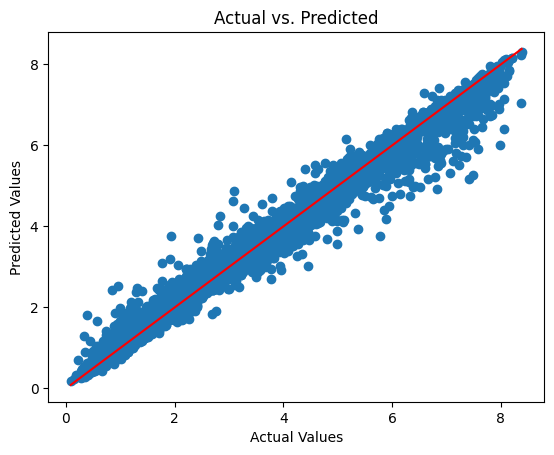

In [ ]:
# plt.scatter(y_test, y_pred)
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Actual vs. Predicted')

# # Calculate the min and max values across both y_test and y_pred
# min_val = min(min(y_test), min(y_pred))
# max_val = max(max(y_test), max(y_pred))

# # Plot the red 1:1 line
# plt.plot([min_val, max_val], [min_val, max_val], color='red')  # 1:1 line

# plt.show()


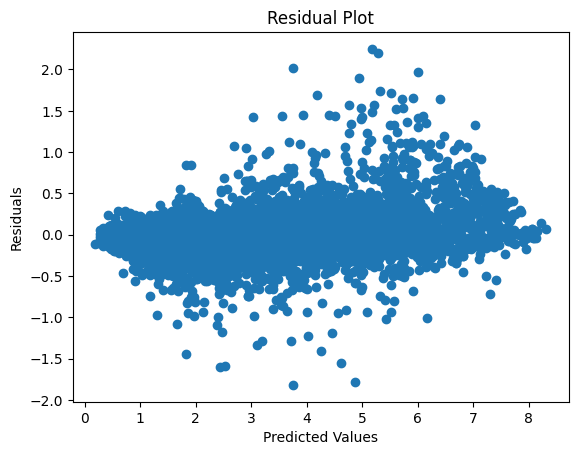

In [ ]:
# residuals = y_test - y_pred
# plt.scatter(y_pred, residuals)
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()


In [ ]:
# num_rows = df_All.shape[0]

# splits = num_rows//10000

# if splits < 5:
#     splits = 5

In [ ]:
# # Define the K-fold cross validator
# kfold = KFold(n_splits=splits, shuffle=True, random_state=42)

# # Perform K-fold cross-validation
# scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# # Take the square root of the scores to get the RMSE
# rmse_scores = np.sqrt(-scores)

# # Print out the results
# print(f'Scores for each fold are: {rmse_scores}')
# print(f'Average RMSE: {np.mean(rmse_scores)}')
# print(f'Standard deviation of RMSE: {np.std(rmse_scores)}')

Scores for each fold are: [0.25194828 0.26215834 0.25989902 0.27071385 0.24770285]
Average RMSE: 0.2584844685877837
Standard deviation of RMSE: 0.008050108116017684


In [ ]:
# df_All.columns

Index(['Date', '425_pct_Al', 'C4_pct_Eth', 'C4_pct_H2O', 'HydWtr_pct_Ammonia',
       'HydWtr_Na2O', 'Decanol', 'DI55102', 'DI55152', 'FC55003', 'FC55009',
       'FC55552', 'FC55569', 'FC55576', 'FFC55555', 'LC90366', 'LC90368',
       'PI55004', 'PI55020', 'TC55552', 'TI55021'],
      dtype='object')

In [ ]:
# import pickle

# # Assuming your model is trained and stored in xgb_model as shown in your code

# # Save the model to disk
# filename = 'C10_xgb_model.sav'
# pickle.dump(xgb_model, open(filename, 'wb'))

# print("Model saved successfully.")


Model saved successfully.
